<a href="https://colab.research.google.com/github/ajurberg/article-parser/blob/main/06_gensim_word2vec_gdf11_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################# 
#@title Installation of libraries 
#############################
import os
from time import time
import re, string, unicodedata
from string import punctuation
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict  # For word frequency

In [2]:
############################# 
#@title Mounting Google Drive
#############################
from google.colab import drive
drive._mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/papers'
os.chdir(workdir_path)

Mounted at /content/drive


In [3]:
############################# 
#@title Read json file to dictionary
#############################
import json

with open("gdf11-dictionary-word-tokens-stop.json") as json_file:
  gdf11_dict = json.load(json_file)

#@markdown Files to evaluate
#@markdown - gdf11-dictionary.json (no preprocessing)
#@markdown - gdf11-dictionary-sent-tokens.json
#@markdown - gdf11-dictionary-sent-tokens-stop.json
#@markdown - gdf11-dictionary-word-tokens.json
#@markdown - gdf11-dictionary-word-tokens-stop.json

In [4]:
############################# 
#@title Gensim Word2Vec
#############################
#@markdown https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
! pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [5]:
# Additional libraries
import gensim
import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

In [ ]:
############################# 
#@title Training my own model
#############################
from gensim.test.utils import datapath
from gensim import utils
import gensim.models

VECTOR_SIZE = 300    #@param {type:"number"}
#@markdown - `Vector size` refers to the number of dimensions of the embeddings. The default is `100`
WINDOW = 5          #@param {type:"number"}
#@markdown - `Window` refers to the maximum distance between a target word and words around the target word. The default is `5`
MIN_COUNT = 5       #@param {type:"number"}
#@markdown - `min_count` refers to the minimum count of words to consider when training the model. Words with occurrence less than this count will be ignored. The default is `5`
WORKERS = 5         #@param {type:"number"}
#@markdown - `workers` refers to the number of partitions during training. The default is `3`
SG = 0              #@param {type:"number"}
#@markdown - `sg` refers to the training algorithm:
#@markdown * `0` for `CBOW` (It uses context to predict a target word)
#@markdown * `1` for `skipgram` (It uses a word to predict a target context)

model = Word2Vec(sentences=gdf11_dict.values(),
                 vector_size=VECTOR_SIZE,
                 window=WINDOW,
                 min_count=MIN_COUNT,
                 workers=WORKERS,
                 sg=SG)

model.save("word2vec-gdf11.model")

In [19]:
############################# 
#@title Load own model
#############################
FILEPATH = '/content/drive/My Drive/papers'   #@param {type:"string"}
model = gensim.models.Word2Vec.load(FILEPATH + "/word2vec-gdf11.model")

INFO - 02:00:21: loading Word2Vec object from /content/drive/My Drive/papers/word2vec-gdf11.model
INFO - 02:00:23: loading wv recursively from /content/drive/My Drive/papers/word2vec-gdf11.model.wv.* with mmap=None
INFO - 02:00:23: setting ignored attribute cum_table to None
INFO - 02:00:23: Word2Vec lifecycle event {'fname': '/content/drive/My Drive/papers/word2vec-gdf11.model', 'datetime': '2022-01-15T02:00:23.456700', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}


In [ ]:
############################# 
#@markdown To obtain vectors for terms the model is familiar with
#############################
WORD = 'gdf11'    #@param {type:"string"}

try:
  print(model.wv[WORD.lower()])
except KeyError:
  print(f"The word '{WORD}' does not appear in this model.")

In [24]:
############################# 
#@markdown Retrieve vocabulary
#############################
for index, word in enumerate(model.wv.index_to_key):
  if index == 10:
    break
  print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/22739 is ,
word #1/22739 is .
word #2/22739 is )
word #3/22739 is (
word #4/22739 is gdf11
word #5/22739 is ;
word #6/22739 is :
word #7/22739 is cells
word #8/22739 is expression
word #9/22739 is mice


In [27]:
############################# 
#@markdown Compute similarities
#############################
WORD_1 = 'transcription'    #@param {type:"string"}
WORD_2 = 'gdf11'     #@param {type:"string"}

try:
  print(model.wv.similarity(WORD_1.lower(), WORD_2.lower()))
except KeyError:
  print(f"Word(s) not present")

0.113783345


In [30]:
############################# 
#@markdown Print the most similar words
#############################
WORD = 'gdf11'    #@param {type:"string"}
TOPN = 5          #@param {type:"number"}
#@markdown - `TOPN` refers to the number of words

print(model.wv.most_similar(positive=[WORD.lower()], topn=TOPN))
# Based on Euclidean distance - it does not work well for high-dimensional word vectors
# Euclidean similarity increases as the number of dimensions increases

[('rgdf11', 0.6043880581855774), ('gdf-11', 0.5938850045204163), ('fto', 0.5570193529129028), ('exogenous', 0.548626720905304), ('opposite', 0.5396591424942017)]


In [31]:
############################# 
#@markdown Cosine similarity between two words
#############################
WORD_1 = 'gdf11'    #@param {type:"string"}
WORD_2 = 'bmp11'    #@param {type:"string"}

cosine_similarity = np.dot(model.wv[WORD_1], model.wv[WORD_2])/(np.linalg.norm(model.wv[WORD_1]) * np.linalg.norm(model.wv[WORD_2]))
print(f"cosine similarity between '{WORD_1}' and '{WORD_2}': {cosine_similarity}")

cosine similarity between 'gdf11' and 'bmp11': 0.5267656445503235


In [32]:
############################# 
#@markdown Cosine similarity between vector lists
#############################
# It measures the cosine of the angle between two vectors projected in a multi-dimensional space
# It captures the angle of the word vectors (not the magnitude)
# No similarity is expressed as a 90-degree angle 
# Total similarity of 1 is at a 0-degree angle

def cosine_distance(model, word, target_list, num):
  cosine_dict ={}
  word_list = []
  a = model.wv[word]
  for item in target_list:
    if item != word:
      b = model.wv[item]
      cos_sim = dot(a, b)/(norm(a)*norm(b))
      cosine_dict[item] = cos_sim
  dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descending order 
  
  for item in dist_sort:
    word_list.append((item[0], item[1]))
  return word_list[0:num]

# Target list
target_list = ['cell', 'bmp11', 'apoptosis', 'dna', 'phagocytosis', 'migration', 'aging']

# Show the most similar word by cosine distance
WORD = 'gdf11'    #@param {type:"string"}
cosine_distance(model, WORD, target_list, 5)

[('bmp11', 0.52676564),
 ('aging', 0.30453503),
 ('apoptosis', 0.2983984),
 ('migration', 0.27337718),
 ('phagocytosis', 0.12151204)]

In [34]:
############################# 
#@title Model Evaluation
#############################
from gensim.test.utils import datapath

model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

INFO - 02:04:05: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 02:04:05: built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
INFO - 02:04:05: Dictionary lifecycle event {'msg': "built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)", 'datetime': '2022-01-15T02:04:05.523667', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
INFO - 02:04:05: Pearson correlation coefficient against /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/wordsim353.tsv: 0.0925
INFO - 02:04:05: Spearman rank-order correlation coefficient against /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/wordsim353.tsv: 0.0929
INFO - 02:04:05: Pairs with unknown words ratio: 72.0%


((0.09252733547396436, 0.3623485117921968),
 SpearmanrResult(correlation=0.09292919306389757, pvalue=0.36025857687026386),
 71.95467422096317)

In [35]:
############################# 
#@title t-SNE visualization
#############################
! pip install scikit-learn==0.19.0

     |████████████████████████████████| 9.3 MB 4.7 MB/s 
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
    Running setup.py install for scikit-learn ... error
  Rolling back uninstall of scikit-learn
  Moving to /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.2.dist-info/
   from /usr/local/lib/python3.7/dist-packages/~cikit_learn-1.0.2.dist-info
  Moving to /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/
   from /usr/local/lib/python3.7/dist-packages/~cikit_learn.libs
  Moving to /usr/local/lib/python3.7/dist-packages/sklearn/
   from /usr/local/lib/python3.7/dist-packages/~klearn
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-ins

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_style("darkgrid")

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sklearn.__version__

'1.0.2'

In [37]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, VECTOR_SIZE), dtype='f') # CHANGE HERE for array size
    word_labels = [word]
    color_list  = ['red']

    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=num_dimensions).fit_transform(arrays) # 50
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(f't-SNE visualization for {word.title()}')

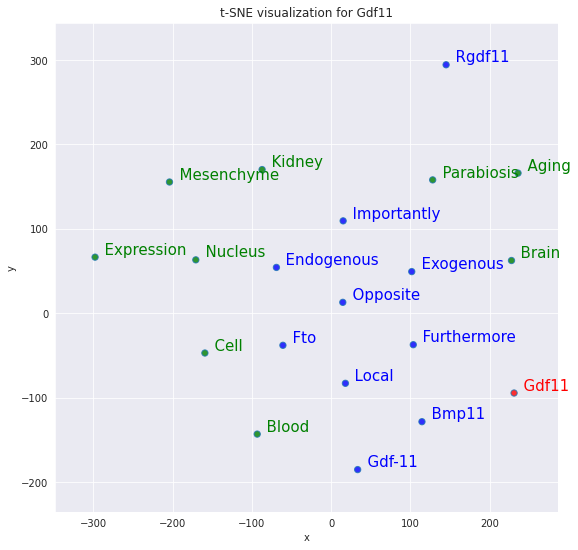

In [40]:
#@markdown Compares where the vectorial representation of the ´FIRST_WORD´ and its 10 most similar words are positioned on a 2D plot in comparison with 8 random words.
VECTOR_SIZE = 300     #@param {type:"number"}
FIRST_WORD = "gdf11"  #@param {type:"string"}
random_words = ['cell', 'expression', 'mesenchyme', 'brain', 'nucleus', 'kidney', 'blood', 'aging', 'parabiosis']

tsnescatterplot(model, FIRST_WORD, random_words)

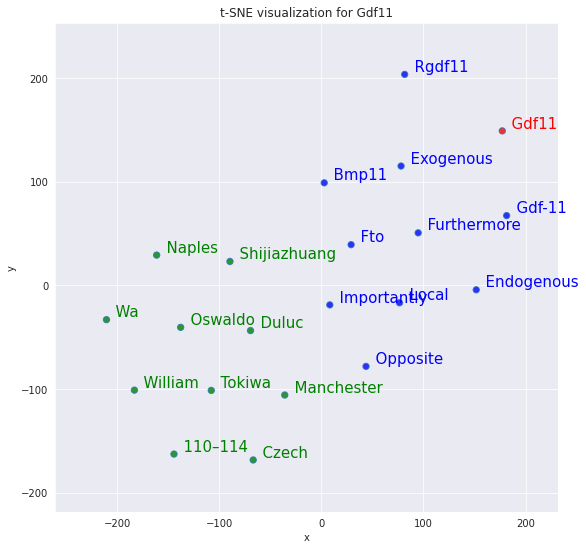

In [41]:
#@markdown Compares where the vectorial representation of the ´FIRST_WORD´ and its 10 most similar words are positioned on a 2D plot in comparison with its 10 most dissimilar words.

FIRST_WORD = "gdf11" #@param {type:"string"}

tsnescatterplot(model, FIRST_WORD, [i[0] for i in model.wv.most_similar(negative=[FIRST_WORD])])

# Not used

In [ ]:
############################# 
#@title Load a pre-trained model
#############################
#@markdown Pre-trained model was downloaded from http://bioasq.org/news/bioasq-releases-continuous-space-word-vectors-obtained-applying-word2vec-pubmed-abstracts
# Alternatively, it possible to train my own model - see code snippet below (>Not used)

# To unzip tar.gz files
#! gzip -d "/content/drive/My Drive/papers/biomedicalWordVectors.tar.gz"


In [ ]:
# To extract tar file
#! tar -xvf "/content/drive/My Drive/papers/biomedicalWordVectors.tar"

word2vecTools/toolkit.py
word2vecTools/vectors.txt
word2vecTools/
word2vecTools/README_BioASQ_word_vectors.pdf
word2vecTools/types.txt
word2vecTools/train_vectors.sh


In [ ]:
import warnings  
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')  
warnings.filterwarnings(action='ignore', category=FutureWarning, module='gensim')

# To load the `vectors.txt` file - It takes about 30 minutes to load the file
FILEPATH = '/content/drive/My Drive/papers/word2vecTools/'
model = gensim.models.KeyedVectors.load_word2vec_format(FILEPATH + 'vectors.txt', binary=False, no_header=True) # binary=True
model.save("biomedWV.model")

In [ ]:
############################# 
#@title Visualization of Word Embeddings
#############################
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # Extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # Reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)